In [17]:
import numpy as np
import pandas as pd
import emcee
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Rosenbrock Density

In [2]:
# define logarithm of density function 
def lnprob(theta):
    return -1./20 * (100*(theta[1] - theta[0]**2)**2 + (1-theta[0])**2)

In [3]:
# create meshgrid and associated lnprobs 
xx, yy = np.mgrid[-10:10:.01, -10:10:.01]
print('xx shape: {} | yy shape: {}'.format(xx.shape, yy.shape))
pos = np.vstack([xx.ravel(), yy.ravel()])
print('pos shape: {}'.format(pos.shape))
n_pos = xx.shape[0] * xx.shape[1]
lnprobs = np.array([lnprob(pos[:,i]) for i in range(n_pos)])
lnprobs = np.reshape(lnprobs, xx.shape)
print('lnprobs shape: {}'.format(lnprobs.shape))

xx shape: (2000, 2000) | yy shape: (2000, 2000)
pos shape: (2, 4000000)
lnprobs shape: (2000, 2000)


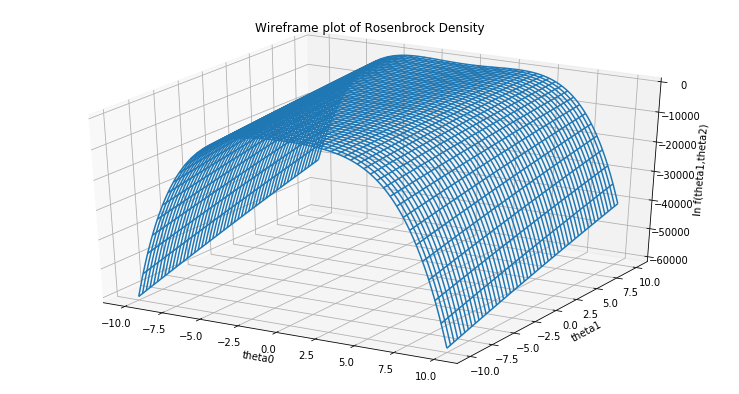

In [4]:
# create the plot
fig = plt.figure(figsize=(13, 7))
ax = fig.gca(projection='3d')
w = ax.plot_wireframe(xx, yy, lnprobs)
ax.set_xlabel('theta0')
ax.set_ylabel('theta1')
ax.set_zlabel('ln f(theta1,theta2)')
ax.set_title('Wireframe plot of Rosenbrock Density');

Based on the Rosenbrock Density wireframe plot above, we posit that: 
- (theta1, theta2) = (0,0) seems to be a good place to initialize our MCMC walker 
- theta0 has a smaller variance than theta1, which might instruct us to pick a larger variance for the latter in our proposal function 

## Diagnostic Helper Functions 

In [5]:
def convergence_heuristics(samples, n_segments=4):
    """ Perform basic convergence check by splitting up chain into N continuous segments (default=4) 
        to see if they exhibit similar empirical means and variances """
    
    # convert samples to pandas for easy data manipulation
    df = pd.DataFrame(samples, columns=['theta0', 'theta1'])
    
    # split into segments 
    samples_per_segment = len(df) / n_segments
    df['segment'] = np.floor(df.index / samples_per_segment).astype(int) + 1
    
    # compute mean and std for each parameter in each segment 
    stats = df.groupby('segment')['theta0', 'theta1'].agg([np.mean, np.std])
    
    return np.round(stats,3).T

In [37]:
def trace_plot(samples):
    """ Plots parameter samples as a function of step number """
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 7))

    for i, ax in enumerate(axes):
        param_vals = pd.Series(my_samples[:,i])
        ax.plot(param_vals, label='Theta{}'.format(i))
        ax.set_xlabel('Step Number')
        ax.set_ylabel('Theta{} Value'.format(i))
        ax.legend()

    plt.tight_layout()

In [7]:
def plot_1d_histograms(samples): 
    """ Plots histograms of each parameter's samples side-by-side. 
        Accepts an array for a single model, or a dictionary for comparison of multiple models (latter overlayed) """

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # convert input to dict if not already a dict 
    samples_dict = samples if isinstance(samples, dict) else {'my_sampler': samples}
    
    for i, ax in enumerate(axes):
        for sampler in samples_dict.keys(): 
            ax.hist(samples_dict[sampler][:,i], bins=100, histtype='step', density=True, label=sampler)
            ax.set_ylabel('Density')
            ax.set_xlabel('Theta{}'.format(i+1))
            ax.set_title('Distribution of Theta{}'.format(i+1))
            ax.legend()

In [8]:
def plot_2d_scatterplot(samples_dict, samples_to_plot=10000):
    """ Compares scatter plots of (theta1, theta2) samples between two samplers """
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=True)

    for i, (ax, sampler) in enumerate(zip(axes, samples_dict.keys())):
        
        # thin chain to prevent scatterplot from being a giant blob 
        samples = samples_dict[sampler]
        idx = np.random.randint(len(samples), size=samples_to_plot)
        thinned = samples[idx, :]

        # create scatterplot
        ax.scatter(thinned[:,0], thinned[:,1], alpha=0.1, s=1)
        ax.set_xlabel('Theta0')
        ax.set_ylabel('Theta1')
        ax.set_title('Samples from {}'.format(sampler))

## My Sampler

In [10]:
class mySampler():
    
    """ Class representing a basic 2-param M-H sampler, instantiated with a (log) density function and a cov tuple 
        representing the variances of 2 params in a bivariate Gaussian proposal function """
    
    def __init__(self, density, cov): 
        self.density = density 
        self.cov = cov 
    
    def run_mcmc(self, steps, initial_x): 
        
        # initialize x and results variables 
        x = initial_x
        samples = [] 
        accepted = 0

        # start walker 
        for i in range(steps):
            r = np.random.uniform()
            proposed_x = np.random.multivariate_normal(mean=[x[0],x[1]], cov=self.cov)
            if lnprob(proposed_x) - lnprob(x) > np.log(r):
                x = proposed_x
                accepted += 1 
            samples.append(x)
        
        # compile and return results 
        self.samples = np.array(samples)
        self.accepted_frac = accepted / steps
        print("MCMC completed. Acceptance fraction is {0:.3f}".format(self.accepted_frac))
        return self.samples, self.accepted_frac

#### Tune covariance matrix using acceptance fraction 

Previously we posited by visualizing the Rosenbrock Density that theta0 has a smaller variance than theta1, thus when tuning the covariance matrix we try not only multiples of the identity matrix, but also matrices where theta1 has a greater variance than theta0. To this end, we run MCMC and evaluate acceptance fraction of a grid of (var0, var1) separated by factors of 2 (between $2^{-4}$ and $2^{4}$ for only combos where var0 <= var1: 

In [14]:
factors_of_2 = [2.0**i for i in np.arange(-4,5)]
combos = [[v0, v1] for v0 in factors_of_2 for v1 in factors_of_2 if v0 <= v1] 
results = []

for i, var in enumerate(combos): 
    test_cov = [[var[0],0],[0,var[1]]]
    my_sampler = mySampler(lnprob, cov=test_cov)
    print("Testing covariance matrix {}...".format(test_cov))
    _, my_accept_frac = my_sampler.run_mcmc(steps=10**5, initial_x=(0,0))
    result = {} 
    result['v0'] = var[0]
    result['v1'] = var[1]
    result['accept_frac'] = my_accept_frac
    results.append(result)

Testing covariance matrix [[0.0625, 0], [0, 0.0625]]...
MCMC completed. Acceptance fraction is 0.406
Testing covariance matrix [[0.0625, 0], [0, 0.125]]...
MCMC completed. Acceptance fraction is 0.152
Testing covariance matrix [[0.0625, 0], [0, 0.25]]...
MCMC completed. Acceptance fraction is 0.298
Testing covariance matrix [[0.0625, 0], [0, 0.5]]...
MCMC completed. Acceptance fraction is 0.303
Testing covariance matrix [[0.0625, 0], [0, 1.0]]...
MCMC completed. Acceptance fraction is 0.269
Testing covariance matrix [[0.0625, 0], [0, 2.0]]...
MCMC completed. Acceptance fraction is 0.215
Testing covariance matrix [[0.0625, 0], [0, 4.0]]...
MCMC completed. Acceptance fraction is 0.163
Testing covariance matrix [[0.0625, 0], [0, 8.0]]...
MCMC completed. Acceptance fraction is 0.127
Testing covariance matrix [[0.0625, 0], [0, 16.0]]...
MCMC completed. Acceptance fraction is 0.094
Testing covariance matrix [[0.125, 0], [0, 0.125]]...
MCMC completed. Acceptance fraction is 0.337
Testing cova

In [15]:
results_df = pd.DataFrame(results)
results_df.to_csv('cov_grid_search.csv', index=False)

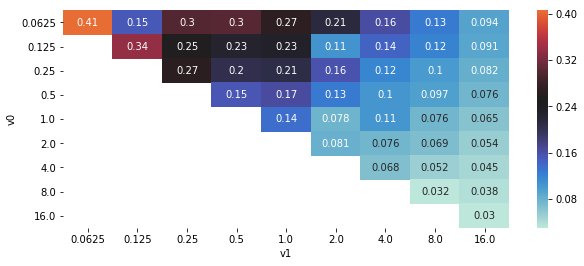

In [26]:
results_df = pd.read_csv('cov_grid_search.csv')
results_summary = pd.DataFrame(results_df).pivot(index='v0', columns='v1', values='accept_frac').round(3)
plt.figure(figsize=(10,4))
sns.heatmap(results_summary, annot=True, center=0.25);

According to Hogg & Foreman-Mackey, the "Goldilocks value for the acceptance fraction is between a half and about a quarter". Based on our grid search above, many covariance matrices above fit the bill. I decided to go with (0.0625, 1.000) which is on the higher end of plausible options to give the walker more latitude to explore the space.

#### Run MCMC with chosen covariance matrix 

In [28]:
best_cov = [[0.0625,0],[0,1.]]
my_sampler = mySampler(lnprob, cov=best_cov)
my_samples, my_accept_frac = my_sampler.run_mcmc(steps=10**6, initial_x=(0,0))

MCMC completed. Acceptance fraction is 0.254


In [32]:
convergence_stats = convergence_heuristics(my_samples, n_segments=4) 
convergence_stats

segment          1       2      3       4
theta0 mean  0.446   1.341  0.701   0.884
       std   2.593   3.544  2.423   2.882
theta1 mean  6.925  14.363  6.361   9.082
       std   8.009  15.144  7.128  10.527

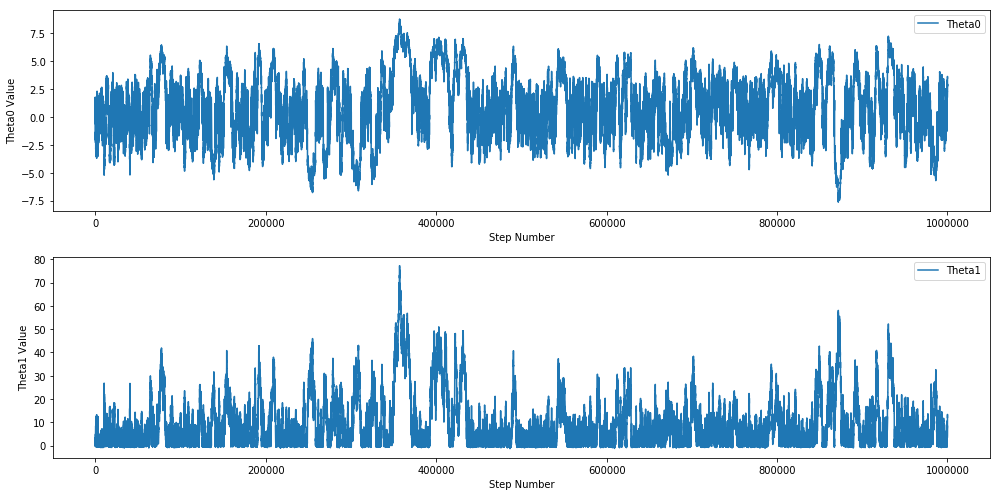

In [38]:
trace_plot(my_samples)

Convergence stats and diagnostic plots look good enough. Marginal distributions of each parameter seem reasonable as well. 

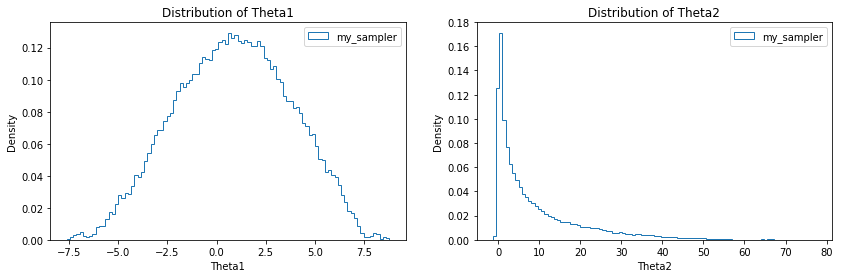

In [39]:
plot_1d_histograms(my_samples)

## Using emcee 

In [36]:
# initialize sampler 
ndim, nwalkers = 2, 10
theta0 = np.random.rand(ndim*nwalkers).reshape((nwalkers, ndim))
emcee_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# burn in
pos, prob, state = emcee_sampler.run_mcmc(theta0, 100);
emcee_sampler.reset() 

# get samples 
emcee_sampler.run_mcmc(pos, 10**5)
emcee_samples = emcee_sampler.flatchain
emcee_accept_frac = np.mean(emcee_sampler.acceptance_fraction)
print("MCMC with emcee sampler completed. Mean acceptance fraction is {0:.3f}".format(emcee_accept_frac))

MCMC with emcee sampler completed. Mean acceptance fraction is 0.235


## Comparing our Samplers

### Efficiency 

In [47]:
# compare acceptance function 
print("Emcee sampler achieved very similar acceptance fraction as mine:")
print("Emcee sampler: {0:.3f}".format(emcee_accept_frac))
print("My sampler: {0:.3f}".format(my_accept_frac))

Emcee sampler achieved very similar acceptance fraction as mine:
Emcee sampler: 0.235
My sampler: 0.254


### Distribution of Samples

Our distribution of samples look remarkably similar as well - not bad for such a simple M-H MCMC sampler that we wrote!

#### 1D marginal distribution (histogram)

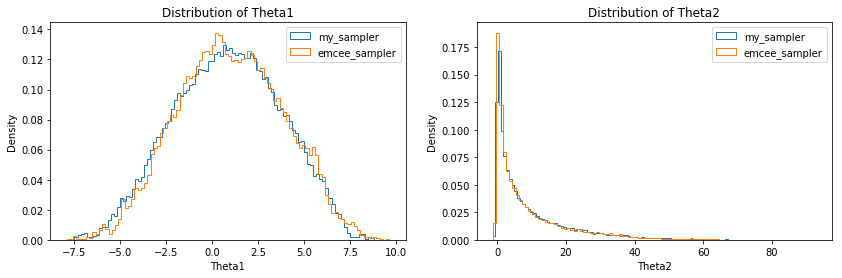

In [42]:
compare_samples = {'my_sampler': my_samples, 'emcee_sampler': emcee_samples} 
plot_1d_histograms(compare_samples)

#### 2D bivariate distribution (scatterplot)

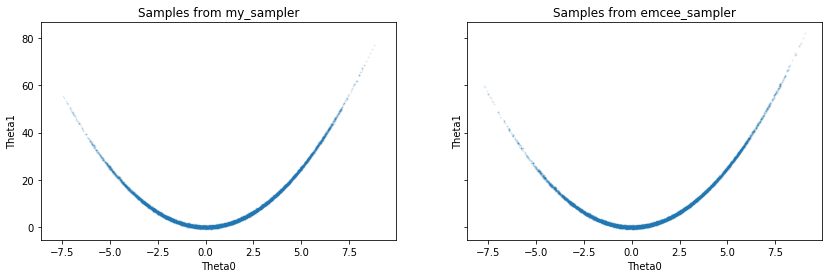

In [43]:
plot_2d_scatterplot(compare_samples)